In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [36]:
data = pd.read_csv('RedWineQuality.csv', sep=';')

# Создание бинарной целевой переменной
data['quality_bin'] = (data['quality'] >= 6).astype(int)

# Выбор признаков и целевой переменной
features = ['volatile acidity', 'density', 'alcohol', 'sulphates']
#X = data[features]
X = data.drop(['quality_bin', 'quality'], axis=1)
y = data['quality_bin']


In [37]:
# Загрузка данных
if False:
    data = pd.read_csv('Never Trust Summary Statistics.tsv', delimiter="\t")

    # Создание бинарной целевой переменной
    data.loc[ data["dataset"] != 'bullseye', "dataset"] = 0
    data.loc[ data["dataset"] == 'bullseye', "dataset"] = 1
    data["dataset"] = data["dataset"].astype(int)

    # Выбор признаков и целевой переменной
    features = ['x', 'y']
    X = data[features]
    y = data['dataset']


# Разделение данных: 60% train, 20% validation, 20% test

In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [39]:
# Базовые классификаторы для Stacking
base_classifiers = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

# Параметры для GridSearchCV
param_grid = {
    'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 10, 50]},
    'AdaBoost': {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1]},
    'Bagging': {'n_estimators': [10, 50, 100]}
}
param_grid['Stacking'] = {
    'final_estimator': [LogisticRegression(max_iter=1000)],
    'passthrough': [True, False]
}

# Обучение и подбор параметров
models = {
    'RandomForest': GridSearchCV(
        RandomForestClassifier(random_state=42), 
        param_grid['RandomForest'], 
        cv=5),
    'AdaBoost': GridSearchCV(
        AdaBoostClassifier(random_state=42), 
        param_grid['AdaBoost'], 
        cv=5),
    'Bagging': GridSearchCV(
        BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42), 
        param_grid['Bagging'], 
        cv=5)
}
models['Stacking'] = GridSearchCV(
    StackingClassifier(estimators=base_classifiers),
    param_grid['Stacking'],
    cv=5
)

# Обучение моделей с подбором параметров
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Используем валидационный набор для GridSearchCV
    print(f"{name} best params: {model.best_params_}")


RandomForest best params: {'max_depth': None, 'n_estimators': 100}
AdaBoost best params: {'learning_rate': 0.1, 'n_estimators': 100}
Bagging best params: {'n_estimators': 100}
Stacking best params: {'final_estimator': LogisticRegression(max_iter=1000), 'passthrough': False}


# Одиночные классификаторы (для сравнения)

In [40]:
single_models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Обучение одиночных классификаторов на тренировочных данных
for name, model in single_models.items():
    model.fit(X_train_scaled, y_train)


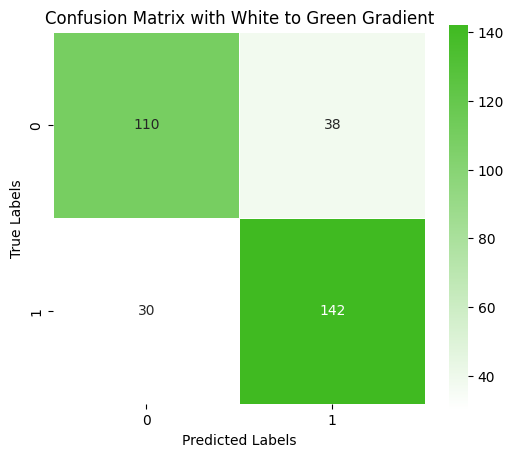

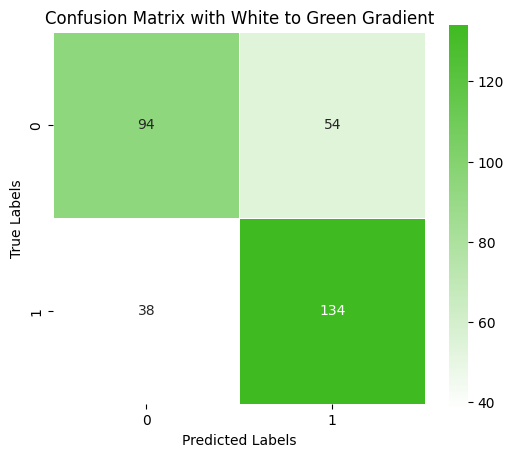

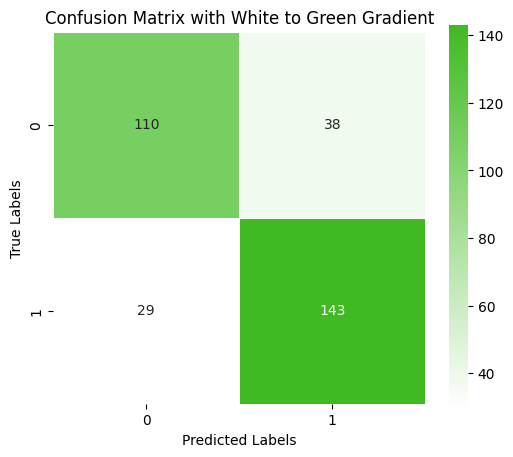

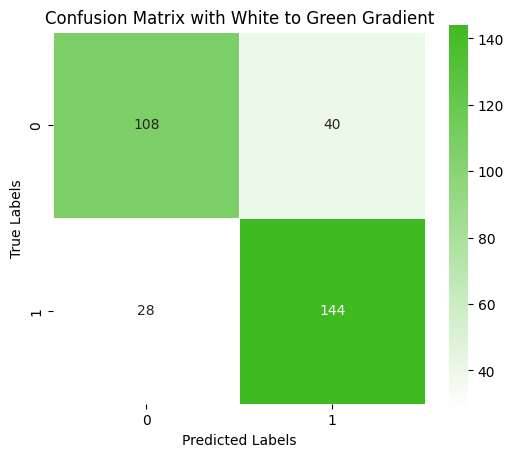

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
corp_col = '#40ba21'

# Функция для вычисления метрик
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

# Оценка ансамблей на тестовых данных
results = {}
for name, model in models.items():
    results[name], cm = evaluate_model(model, X_test_scaled, y_test)
    
    
    # Исходный зеленый цвет в HEX
    hex_green_color = corp_col

    # Преобразуем hex-код в tuple (R,G,B)
    rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

    # Создаем градиент от белого (1,1,1) до нашего зеленого цвета
    colors = [(1, 1, 1), rgb_green_color]

    # Создаем линейную сегментированную цветовую карту
    c_map = LinearSegmentedColormap.from_list("", colors)

    # Строим матрицу ошибок с градиентом цветов
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with White to Green Gradient")
    plt.show()

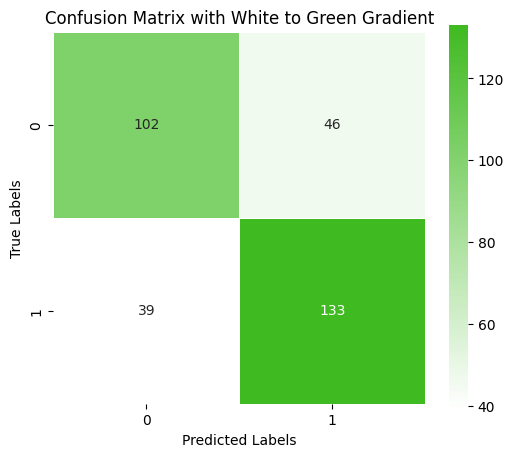

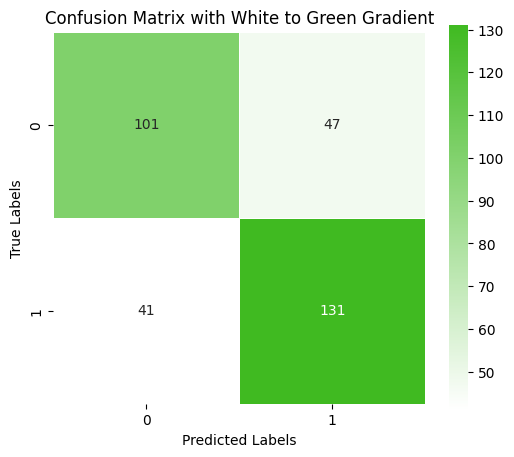

                    Accuracy  Precision    Recall        F1       AUC
RandomForest        0.787500   0.788889  0.825581  0.806818  0.784412
AdaBoost            0.712500   0.712766  0.779070  0.744444  0.707102
Bagging             0.790625   0.790055  0.831395  0.810198  0.787319
Stacking            0.787500   0.782609  0.837209  0.808989  0.783470
DecisionTree        0.734375   0.743017  0.773256  0.757835  0.731223
LogisticRegression  0.725000   0.735955  0.761628  0.748571  0.722030


In [46]:

# Оценка одиночных классификаторов
for name, model in single_models.items():
    results[name], cm = evaluate_model(model, X_test_scaled, y_test)
    # Исходный зеленый цвет в HEX
    hex_green_color = corp_col

    # Преобразуем hex-код в tuple (R,G,B)
    rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

    # Создаем градиент от белого (1,1,1) до нашего зеленого цвета
    colors = [(1, 1, 1), rgb_green_color]

    # Создаем линейную сегментированную цветовую карту
    c_map = LinearSegmentedColormap.from_list("", colors)

    # Строим матрицу ошибок с градиентом цветов
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with White to Green Gradient")
    plt.show()
    
# Сравнение результатов
results_df = pd.DataFrame(results).T
print(results_df)

# Сравнение результатов

## Все множественные классификаторы показали более высокий AUC, на уровне 0.78, кроме AdaBoost (AUC = 0.7). В то время как одиночные классификаторы показали AUC на уровне 0.72-0.73, что тоже хороший результат, тем не менее множественные классификаторы показали себя лучше.